In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('/content/saved_iot_new_data.csv')

In [ ]:
df.head()

,current,voltage,temp,dt_hours,ah_consumed,total_ah_used,True_SoC
0,3.041,12.15,31.0,0.000278,0.000845,0.000845,99.994743
1,3.041,12.14,31.0,0.000278,0.000845,0.001689,99.989487
2,3.025,12.15,31.0,0.000278,0.000840,0.002530,99.984258
3,2.977,12.17,31.0,0.000278,0.000827,0.003357,99.979111
4,3.001,12.17,31.0,0.000278,0.000834,0.004190,99.973924


## Prepare Data for PINN

### Subtask:
Load the dataset and perform any necessary preprocessing, such as scaling features. Identify the input features and the target variable (True_SoC) for the PINN.


**Reasoning**:
I will prepare the data for the PINN model by identifying features and the target, scaling them using `MinMaxScaler`, splitting the data into training, validation, and test sets, and finally converting them into PyTorch tensors, as per the instructions.



In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch

# 1. Identify input features and target variable
features = ['current', 'voltage', 'temp', 'dt_hours', 'ah_consumed', 'total_ah_used']
target = ['True_SoC']

X_data = df[features]
y_data = df[target]

# 2. Apply MinMaxScaler to normalize both features and target
scaler_x_pinn = MinMaxScaler()
scaler_y_pinn = MinMaxScaler()

X_scaled_pinn = scaler_x_pinn.fit_transform(X_data)
y_scaled_pinn = scaler_y_pinn.fit_transform(y_data)

# 3. Split the scaled data into training, validation, and test sets
# Split into training and temporary (test + validation) sets
X_train_pinn, X_temp_pinn, y_train_pinn, y_temp_pinn = train_test_split(X_scaled_pinn, y_scaled_pinn, test_size=0.3, random_state=42)

# Split the temporary set into test and validation sets (0.5 of 0.3 = 0.15 of original for each)
X_val_pinn, X_test_pinn, y_val_pinn, y_test_pinn = train_test_split(X_temp_pinn, y_temp_pinn, test_size=0.5, random_state=42)

print(f"Shape of X_train_pinn: {X_train_pinn.shape}, y_train_pinn: {y_train_pinn.shape}")
print(f"Shape of X_val_pinn: {X_val_pinn.shape}, y_val_pinn: {y_val_pinn.shape}")
print(f"Shape of X_test_pinn: {X_test_pinn.shape}, y_test_pinn: {y_test_pinn.shape}")

# 4. Convert to PyTorch Tensors
X_train_pinn = torch.tensor(X_train_pinn, dtype=torch.float32)
y_train_pinn = torch.tensor(y_train_pinn, dtype=torch.float32)
X_val_pinn = torch.tensor(X_val_pinn, dtype=torch.float32)
y_val_pinn = torch.tensor(y_val_pinn, dtype=torch.float32)
X_test_pinn = torch.tensor(X_test_pinn, dtype=torch.float32)
y_test_pinn = torch.tensor(y_test_pinn, dtype=torch.float32)

print("Data prepared for PINN: features and target identified, scaled, split, and converted to PyTorch tensors.")

Shape of X_train_pinn: (14813, 6), y_train_pinn: (14813, 1)
Shape of X_val_pinn: (3174, 6), y_val_pinn: (3174, 1)
Shape of X_test_pinn: (3175, 6), y_test_pinn: (3175, 1)
Data prepared for PINN: features and target identified, scaled, split, and converted to PyTorch tensors.


## Define Physical Equations for SoC

Specifying  the governing physical equations or constraints related to the State of Charge (SoC) of the battery system.



To integrate physics into the neural network model for SoC prediction, we will leverage the fundamental principles of battery operation,the **Coulomb Counting** method, and incorporate physical constraints. These equations will form the physics-informed component of the loss function for our Physiics block

### 1. Differential Equation for State of Charge (SoC)(researched)

The primary physical equation governing the change in SoC is based on the integration of current over time. This is known as Coulomb Counting. The rate of change of SoC is directly proportional to the current flowing into or out of the battery and inversely proportional to its nominal capacity.

**Equation:**

```
d(SoC)/dt = - (I / Q_nominal) * 100
```

Where:
*   `SoC`: The State of Charge, expressed as a percentage (0-100%). This is the target variable (`True_SoC`).
*   `t`: Time (in hours, consistent with `dt_hours` in the dataset).
*   `I`: The instantaneous current flowing into or out of the battery (in Amperes). In our dataset, this corresponds to the `'current'` feature. A positive `'current'` value in the dataset is associated with a decreasing `True_SoC`, indicating it represents discharge current. Hence, the negative sign in the equation.
*   `Q_nominal`: The nominal (total) capacity of the battery (in Ampere-hours, Ah). This is a constant for a given battery. Based on the dataset where `total_ah_used` goes up to approximately 16 Ah as `True_SoC` drops to 0%, we will assume a **nominal capacity `Q_nominal = 16` Ah** for this battery.
*   The multiplication by `100` converts the fractional change in capacity to a percentage change in SoC.

**Features Used:**
*   `'current'` -> `I`.
*   `dt_hours` implicitly defines the time step `dt` over which the current is considered for integration in a discrete context, but for the differential equation, it defines the unit of time for `d(SoC)/dt` (e.g., % per hour).

**Assumptions Made:**
1.  **Constant Coulombic Efficiency (η):** We assume the Coulombic efficiency is 1 (or constant and absorbed into `Q_nominal`). This means all charge drawn is perfectly converted to discharge, and vice versa. In reality, `η` can vary with SoC, temperature, and current.
2.  **Constant Nominal Capacity:** `Q_nominal` is assumed to be constant and not affected by temperature, aging, or discharge rate. In practice, available capacity can vary.
3.  **No Self-Discharge:** The battery is assumed to have no self-discharge, meaning SoC only changes due to external current flow.
4.  **Instantaneous Current:** The `'current'` feature is treated as the instantaneous current `I` for the differential equation.

### 2. Algebraic Constraints

In addition to the differential equation, physical bounds on the SoC must be enforced:

**Constraints:**
1.  **SoC Bounds:** The State of Charge must always be within the physical limits of 0% and 100%.
    `0 <= SoC <= 100`

These equations and constraints will be formulated into a physics-informed loss term, which will be added to the data-driven mean squared error loss during the PINN training process.

## Build Phy Model Architecture



In [ ]:
import torch.nn as nn

# Define the PINN Model Architecture
class PINN_Model(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim=1):
        super(PINN_Model, self).__init__()

        layers = []
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_layers[0]))
        layers.append(nn.ReLU()) # Using ReLU as activation function

        # Hidden layers
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())

        # Output layer
        layers.append(nn.Linear(hidden_layers[-1], output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Initialize the model
input_dim = X_train_pinn.shape[1] # 6 features
hidden_layers = [32,32] # Adjusted hidden layer configuration
output_dim = 1 # True_SoC

model_pinn = PINN_Model(input_dim, hidden_layers, output_dim)

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pinn.to(device)

# Print model architecture
print("PINN Model Architecture:")
print(model_pinn)
print("PINN model architecture defined, initialized, and moved to device.")

PINN Model Architecture:
PINN_Model(
  (network): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
PINN model architecture defined, initialized, and moved to device.


In [ ]:
import torch.nn.functional as F

def pinn_loss_fn(y_pred, y_true, inputs, model, lambda_physics, scaler_x_pinn, scaler_y_pinn, device, is_training=True):
    """
    Custom PINN loss function combining data-driven loss and physics-informed loss.

    Args:
        y_pred (torch.Tensor): Predicted SoC values from the model (scaled 0-1).
        y_true (torch.Tensor): Actual SoC values from the dataset (scaled 0-1).
        inputs (torch.Tensor): Input features to the model (scaled).
        model (nn.Module): The PINN model itself.
        lambda_physics (float): Weighting factor for the physics loss.
        scaler_x_pinn (MinMaxScaler): Scaler used for input features.
        scaler_y_pinn (MinMaxScaler): Scaler used for the target variable (SoC).
        device (torch.device): The device (CPU/GPU) the tensors are on.
        is_training (bool): If True, compute physics loss; otherwise, only compute data loss.

    Returns:
        torch.Tensor: The total combined loss.
    """
    # 1. Data-driven loss (Mean Squared Error between predicted and actual SoC values)
    data_loss = F.mse_loss(y_pred, y_true)

    physics_loss = torch.tensor(0.0, device=device) # Initialize physics loss

    if is_training:
        # 2. Physics-informed loss
        # To compute derivatives, the inputs tensor (or a copy of it) must have requires_grad=True.
        # It's crucial to create a clone and detach from the original inputs if they were part of a graph,
        # then set requires_grad_ to True for the new tensor for physics calculations.
        inputs_for_physics = inputs.clone().detach()
        inputs_for_physics.requires_grad_(True)

        # Get predicted SoC from the model using inputs_for_physics
        y_pred_physics_scaled = model(inputs_for_physics)

        # a. Identify 'current' and 'dt_hours' features from the `inputs_for_physics` tensor
        # Based on X_data definition: features = ['current', 'voltage', 'temp', 'dt_hours', 'ah_consumed', 'total_ah_used']
        current_scaled = inputs_for_physics[:, 0:1] # 'current' is at index 0
        dt_hours_feature_index = 3 # 'dt_hours' is at index 3

        # b. Compute the gradient of the predicted SoC (`y_pred_physics_scaled`) with respect to the entire `inputs_for_physics`
        gradients_of_y_pred = torch.autograd.grad(
            outputs=y_pred_physics_scaled,
            inputs=inputs_for_physics,
            grad_outputs=torch.ones_like(y_pred_physics_scaled),
            retain_graph=True,
            create_graph=True
        )[0]

        # Extract the gradient corresponding to 'dt_hours' from the computed gradients
        dSoC_dt_scaled_component = gradients_of_y_pred[:, dt_hours_feature_index:dt_hours_feature_index+1]

        # Convert scaled derivative to unscaled derivative: d(SoC_unscaled)/d(dt_unscaled)
        # The scaling factor for dt_hours is needed from scaler_x_pinn.data_range_[dt_hours_feature_index]
        soc_range_tensor = torch.tensor(scaler_y_pinn.data_range_[0], dtype=torch.float32).to(device)
        dt_hours_range_tensor = torch.tensor(scaler_x_pinn.data_range_[dt_hours_feature_index], dtype=torch.float32).to(device)

        # Handle cases where dt_hours_range is zero to prevent division by zero
        if dt_hours_range_tensor == 0.0:
            dSoC_dt_unscaled = torch.zeros_like(dSoC_dt_scaled_component)
        else:
            dSoC_dt_unscaled = dSoC_dt_scaled_component * (soc_range_tensor / dt_hours_range_tensor)

        # Unscale 'current' for the physical equation
        current_min_tensor = torch.tensor(scaler_x_pinn.min_[0], dtype=torch.float32).to(device)
        current_range_tensor = torch.tensor(scaler_x_pinn.data_range_[0], dtype=torch.float32).to(device)
        current_unscaled = current_scaled * current_range_tensor + current_min_tensor

        # c. Define the nominal capacity Q_nominal and convert to tensor
        Q_nominal_tensor = torch.tensor(16.0, dtype=torch.float32).to(device)

        # d. Formulate the physics residual `f_soc`
        # Governing equation: d(SoC)/dt = - (I / Q_nominal) * 100
        # Residual definition (aims to be zero): f_soc = d(SoC)/dt + (I / Q_nominal) * 100
        f_soc = dSoC_dt_unscaled + (current_unscaled / Q_nominal_tensor) * 100.0

        # e. Calculate the mean squared error of `f_soc` with zero
        physics_residual_loss = torch.mean(f_soc**2)

        # f. Implement a penalty for SoC values outside the physical bounds [0, 100]
        # y_pred is scaled (0-1). Inverse transform it to the original scale (0-100).
        y_pred_unscaled_np = scaler_y_pinn.inverse_transform(y_pred.detach().cpu().numpy())
        y_pred_unscaled = torch.tensor(y_pred_unscaled_np, dtype=torch.float32).to(device)

        # Penalty for values less than 0 or greater than 100
        boundary_loss = torch.mean(torch.relu(-y_pred_unscaled)**2) + \
                        torch.mean(torch.relu(y_pred_unscaled - 100)**2)

        # g. Sum the physics residual loss and the boundary penalty to get the total `physics_loss`
        physics_loss = physics_residual_loss + boundary_loss

    # 3. Combine the data loss and the physics loss
    total_loss = data_loss + lambda_physics * physics_loss

    return total_loss

print("Custom PINN loss function `pinn_loss_fn` redefined to handle training/validation modes.")

Custom PINN loss function `pinn_loss_fn` redefined to handle training/validation modes.


In [ ]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

optimizer_pinn = optim.AdamW(model_pinn.parameters(), lr=0.03, weight_decay=0.1) # Added weight_decay

num_epochs_pinn = 100

train_losses_pinn = []
val_losses_pinn = []

BATCH_SIZE_PINN = 64
train_dataset_pinn = TensorDataset(X_train_pinn, y_train_pinn)
val_dataset_pinn = TensorDataset(X_val_pinn, y_val_pinn)

train_dataloader_pinn = DataLoader(train_dataset_pinn, batch_size=BATCH_SIZE_PINN, shuffle=True)
val_dataloader_pinn = DataLoader(val_dataset_pinn, batch_size=BATCH_SIZE_PINN, shuffle=False)

print("Phy nn model train with L2 regularization...")

for epoch in range(num_epochs_pinn):
    #model set to training mode
    model_pinn.train()
    running_train_loss = 0.0

    for X_batch, y_batch in train_dataloader_pinn:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer_pinn.zero_grad()
        y_pred = model_pinn(X_batch)
        total_loss = pinn_loss_fn(y_pred, y_batch, X_batch, model_pinn,
                                  lambda_physics=0.1, scaler_x_pinn=scaler_x_pinn,
                                  scaler_y_pinn=scaler_y_pinn, device=device, is_training=True)

        total_loss.backward()

        #this is updating model parameters
        optimizer_pinn.step()
        running_train_loss += total_loss.item() * X_batch.size(0)

    #average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_dataloader_pinn.dataset)
    train_losses_pinn.append(epoch_train_loss)

    model_pinn.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch_val, y_batch_val in val_dataloader_pinn:

            X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)
            y_pred_val = model_pinn(X_batch_val)
            val_loss = pinn_loss_fn(y_pred_val, y_batch_val, X_batch_val, model_pinn,
                                    lambda_physics=0.1, scaler_x_pinn=scaler_x_pinn,
                                    scaler_y_pinn=scaler_y_pinn, device=device, is_training=False)

            running_val_loss += val_loss.item() * X_batch_val.size(0)

    epoch_val_loss = running_val_loss / len(val_dataloader_pinn.dataset)
    val_losses_pinn.append(epoch_val_loss)
    if (epoch + 1) % 2 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs_pinn}], Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")

print("PINN model training complete.")

Starting PINN model training with L2 regularization...
Epoch [1/100], Train Loss: 31.856716, Val Loss: 0.000034
Epoch [2/100], Train Loss: 30.964140, Val Loss: 0.000024
Epoch [4/100], Train Loss: 30.963510, Val Loss: 0.000013
Epoch [6/100], Train Loss: 30.963554, Val Loss: 0.000052
Epoch [8/100], Train Loss: 30.963538, Val Loss: 0.000036
Epoch [10/100], Train Loss: 30.963678, Val Loss: 0.000065
Epoch [12/100], Train Loss: 30.964056, Val Loss: 0.000140
Epoch [14/100], Train Loss: 30.972450, Val Loss: 0.000045
Epoch [16/100], Train Loss: 30.964929, Val Loss: 0.000489
Epoch [18/100], Train Loss: 30.964662, Val Loss: 0.000193
Epoch [20/100], Train Loss: 30.965081, Val Loss: 0.000546
Epoch [22/100], Train Loss: 30.964921, Val Loss: 0.000666
Epoch [24/100], Train Loss: 30.964984, Val Loss: 0.000022
Epoch [26/100], Train Loss: 30.965418, Val Loss: 0.000142
Epoch [28/100], Train Loss: 30.965766, Val Loss: 0.000085
Epoch [30/100], Train Loss: 30.963525, Val Loss: 0.000017
Epoch [32/100], Train 


PINN Model Performance on Test Data:
Mean Squared Error (MSE): 0.6408
Mean Absolute Error (MAE): 0.6815
R-squared (R2) Score: 0.9993


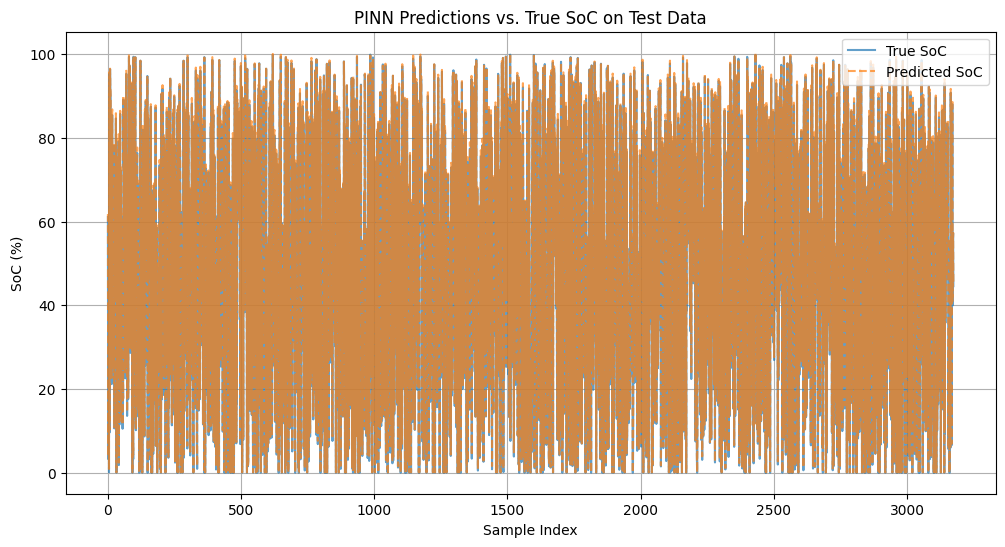


Physics-informed Loss Components on Test Data (Evaluation Mode):
Physics Residual Loss (dSoC/dt term): 310.018219
SoC Boundary Loss (0-100%): 0.000055
Combined Physics Loss: 310.018280
PINN model evaluation complete.


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

model_pinn.eval()

X_test_pinn_device = X_test_pinn.to(device)
y_test_pinn_device = y_test_pinn.to(device)

with torch.no_grad():

    y_pred_test_scaled = model_pinn(X_test_pinn_device)

    # 3. Convert scaled values back to original scale (0-100)
    y_pred_test_unscaled = scaler_y_pinn.inverse_transform(y_pred_test_scaled.cpu().numpy())
    y_test_unscaled = scaler_y_pinn.inverse_transform(y_test_pinn_device.cpu().numpy())


    mse = mean_squared_error(y_test_unscaled, y_pred_test_unscaled)
    mae = mean_absolute_error(y_test_unscaled, y_pred_test_unscaled)
    r2 = r2_score(y_test_unscaled, y_pred_test_unscaled)

    print("\nPINN Model Performance on Test Data:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2) Score: {r2:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_unscaled, label='True SoC', alpha=0.7)
    plt.plot(y_pred_test_unscaled, label='Predicted SoC', alpha=0.7, linestyle='--')
    plt.title('PINN Predictions vs. True SoC on Test Data')
    plt.xlabel('Sample Index')
    plt.ylabel('SoC (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Physics Residual Loss Calculation (outside no_grad to allow gradient computation) ---
# The model is already in eval() mode, but we need to ensure gradients are computed for this specific part.

# prepare inputs for physics loss calculation
inputs_for_physics_test = X_test_pinn_device.clone().detach()
inputs_for_physics_test.requires_grad_(True)

# get predicted SoC from the model using inputs_for_physics
y_pred_physics_scaled_test = model_pinn(inputs_for_physics_test)

# identify 'current' and 'dt_hours' features
current_scaled_test = inputs_for_physics_test[:, 0:1] # 'current' is at index 0
dt_hours_feature_index = 3 # 'dt_hours' is at index 3

# compute the gradient of the predicted SoC with respect to inputs
gradients_of_y_pred_test = torch.autograd.grad(
    outputs=y_pred_physics_scaled_test,
    inputs=inputs_for_physics_test,
    grad_outputs=torch.ones_like(y_pred_physics_scaled_test),
    retain_graph=True,
    create_graph=True
)[0]

# extract the gradient corresponding to 'dt_hours'
dSoC_dt_scaled_component_test = gradients_of_y_pred_test[:, dt_hours_feature_index:dt_hours_feature_index+1]

# unscale derivative components
soc_range_tensor = torch.tensor(scaler_y_pinn.data_range_[0], dtype=torch.float32).to(device)
dt_hours_range_tensor = torch.tensor(scaler_x_pinn.data_range_[dt_hours_feature_index], dtype=torch.float32).to(device)

if dt_hours_range_tensor == 0.0:
    dSoC_dt_unscaled_test = torch.zeros_like(dSoC_dt_scaled_component_test)
else:
    dSoC_dt_unscaled_test = dSoC_dt_scaled_component_test * (soc_range_tensor / dt_hours_range_tensor)

current_min_tensor = torch.tensor(scaler_x_pinn.min_[0], dtype=torch.float32).to(device)
current_range_tensor = torch.tensor(scaler_x_pinn.data_range_[0], dtype=torch.float32).to(device)
current_unscaled_test = current_scaled_test * current_range_tensor + current_min_tensor

Q_nominal_tensor = torch.tensor(16.0, dtype=torch.float32).to(device)

# formulate the physics residual f_soc
f_soc_test = dSoC_dt_unscaled_test + (current_unscaled_test / Q_nominal_tensor) * 100.0
physics_residual_loss_test = torch.mean(f_soc_test**2)

# calculate boundary loss on the predicted values (unscaled)
y_pred_test_unscaled_np_for_boundary = scaler_y_pinn.inverse_transform(y_pred_physics_scaled_test.detach().cpu().numpy())
y_pred_test_unscaled_for_boundary = torch.tensor(y_pred_test_unscaled_np_for_boundary, dtype=torch.float32).to(device)

boundary_loss_test = torch.mean(torch.relu(-y_pred_test_unscaled_for_boundary)**2) + \
                     torch.mean(torch.relu(y_pred_test_unscaled_for_boundary - 100)**2)

total_physics_loss_test = physics_residual_loss_test + boundary_loss_test

print("\nPhysics-informed Loss Components on Test Data (Evaluation Mode):")
print(f"Physics Residual Loss (dSoC/dt term): {physics_residual_loss_test.item():.6f}")
print(f"SoC Boundary Loss (0-100%): {boundary_loss_test.item():.6f}")
print(f"Combined Physics Loss: {total_physics_loss_test.item():.6f}")

print("PINN model evaluation complete.")

In [ ]:
import torch
model_save_path = 'pinn_model_.pth'
torch.save(model_pinn, model_save_path)
print(f"PINN model saved successfully as a complete model object to {model_save_path}")

PINN model saved successfully as a complete model object to pinn_model_.pth
